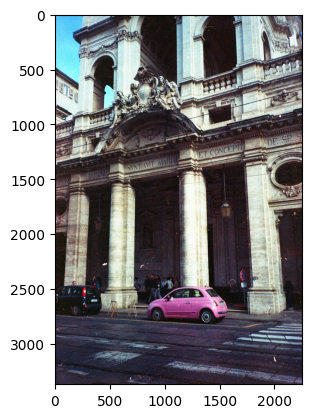

In [224]:
from skimage import segmentation, morphology
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import ndimage
from skimage.io import imread
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.color import label2rgb
from skimage.transform import resize
from PIL import Image
import cv2

# Load the image
image = imread('test.jpg')
# image = imread('lighthouse.png')
# image = imread('bus.png')
# image = cv2.imread('bus.png')

# show image
import matplotlib.pyplot as plt

plt.imshow(image)

In [225]:
maxInt = image.max()
minInt = image.min()
print(maxInt)
print(minInt)

255
0


Resizing image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 341.73871733966746
SLIC number of segments: 264
SLIC segments shape: (512, 342)


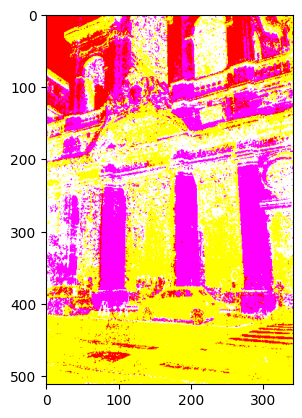

In [226]:
# let us first resize image to prevent memory issues
MAX_EDGE_LENGTH = 512
height = image.shape[0]
width = image.shape[1]
width_height_ratio = height / width

is_width_longer = width > height
should_resize = height > MAX_EDGE_LENGTH or width > MAX_EDGE_LENGTH

resized_image = None

resize_ratio = 1

newWidth = width
newHeight = height

if should_resize:
    print('Resizing image')
    if is_width_longer:
        newWidth = 512
        newHeight = 512 * width_height_ratio
    else:
        newHeight = 512
        newWidth = 512 / width_height_ratio


image = resize(image, (newHeight, newWidth))

print(newHeight, newWidth)

# if 4 channels, remove the alpha channel
if image.shape[2] == 4:
    image = image[:, :, :3]
# image = resize(image, (256, 256))

# Convert the image to Lab color space
lab_image = rgb2lab(image)

# plot lab image

plt.imshow(lab_image)

# Step 1: Apply SLIC algorithm to create superpixels
# n_segments: number of segments (= the desired number of superpixels) -> Superpixel: a group of connected pixels that share similar color
# More superpixels -> more segments -> more detailed segmentation
# compactness: balance between color proximity and space proximity
# sigma: width of Gaussian smoothing kernel

segments = 300
sigma = 1
compactness = 20
segments_slic = segmentation.slic(lab_image, n_segments=segments, compactness=compactness, sigma=sigma) # each pixel is assigned to the superpixel it belongs to (numbered from 1 to n_segments)

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

print('SLIC segments shape: {}'.format(segments_slic.shape))

# plt.imshow(label2rgb(segments_slic, image))


False
Segment count in 1:  254
Segment count in 2:  235
Segment count is different


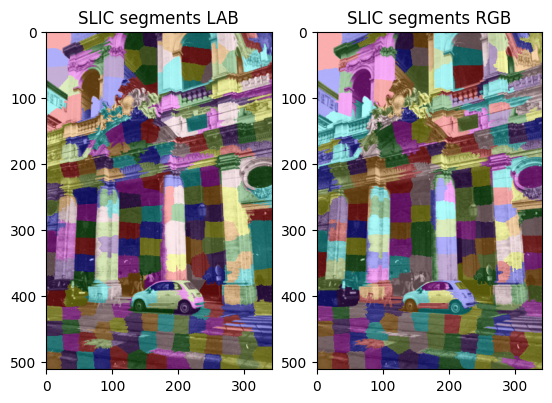

In [227]:
segments_slic1 = segmentation.slic(lab_image, n_segments=segments, compactness=20, sigma=0.5) # each pixel is assigned to the superpixel it belongs to (numbered from 1 to n_segments)
segments_slic2 = segmentation.slic(image, n_segments=segments, compactness=20, sigma=0.5) # each pixel is assigned to the superpixel it belongs to (numbered from 1 to n_segments)

# check if the two are different
print(np.array_equal(segments_slic1, segments_slic2))

# show the parts that are different
segment_count_diff = 0
segments_in_1 = np.unique(segments_slic1)
segments_in_2 = np.unique(segments_slic2)

# check if segment count is different
if len(segments_in_1) != len(segments_in_2):
    print("Segment count in 1: ", len(segments_in_1))
    print("Segment count in 2: ", len(segments_in_2))
    print('Segment count is different')

# plot both images in one plot
fig, (ax1, ax2) = plt.subplots(1, 2)
# add title for each plot
ax1.set_title('SLIC segments LAB')
ax1.imshow(label2rgb(segments_slic1, image))
ax2.set_title('SLIC segments RGB')
ax2.imshow(label2rgb(segments_slic2, image))


In [228]:
# plot slic segment with each segment with representative color (most frequent color in the segment)
# get the unique segments

# lab slic
unique_segments = np.unique(segments_slic1)
# extract most frequent color in each segment
segment_colors = []
for segment in unique_segments:
    segment_mask = segments_slic1 == segment
    segment_lab = lab_image[segment_mask]


In [229]:
from scipy import stats

test_mode = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3]])
print(stats.mode(test_mode, axis=0).mode)


[1 2 3]


In [230]:
average_pixel_count_in_segment = np.average([np.sum(segments_slic1 == segment) for segment in unique_segments])
print('Average pixel count in segment: ', int(average_pixel_count_in_segment))

Average pixel count in segment:  689


In [231]:



dominant_colors = []

i = 0
for segment_label in np.unique(segments_slic):
    mask = segments_slic == segment_label
    # print(lab_image.shape)
    segment_colors = lab_image[mask]
    
    # Find the most frequent color (mode) in the superpixel
    # Mode works on the flattened array, so we reshape to (-1, 3) assuming segment_colors is 3-channel
    # print(segment_colors.shape)
    mode_result = stats.mode(segment_colors, axis=0)
    # kmeans
    # kmeans = KMeans(n_clusters=1).fit(segment_colors)
    # dominant_color_lab = kmeans.cluster_centers_[0]
    # get color that is closest to the cluster center
    nearest_neighbor = NearestNeighbors(n_neighbors=15).fit(segment_colors)
    distances, indices = nearest_neighbor.kneighbors(segment_colors)
    # find the color that has least distance
    
    sum_distances = np.sum(distances, axis=1)
    min_distance_index = np.argmin(sum_distances)
    dominant_color_lab = segment_colors[min_distance_index]
    
    
    # print(distances, indices)
    # dominant_color_lab = mode_result.mode  # Most frequent color in LAB
    # print('Dominant color in segment {}: {}'.format(i, dominant_color_lab))
    # print(dominant_color_lab)
    # dominant_color_lab = dominant_color_lab.reshape(1, 1, 3)  # Reshape for conversion function
    
    # Convert the dominant LAB color to RGB
    dominant_color_rgb = lab2rgb(dominant_color_lab)
    
    # Append the RGB color, scaled to 0-255 range for display
    # print('Dominant color in segment {}: {}'.format(i, dominant_color_rgb))
    dominant_colors.append((dominant_color_rgb))

0.9941940671195569 0.030903131941108754


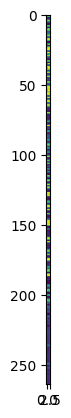

In [232]:
# plot the dominant colors
dominant_colors = np.array(dominant_colors)

max = dominant_colors.max()
min = dominant_colors.min()
print(max, min)
plt.imshow(dominant_colors)

In [233]:
max_int = np.max(dominant_colors)
min_int = np.min(dominant_colors)
print('max_int: {}'.format(max_int))
print('min_int: {}'.format(min_int))

max_int: 0.9941940671195569
min_int: 0.030903131941108754


(512, 342, 3)
(512, 342, 3)


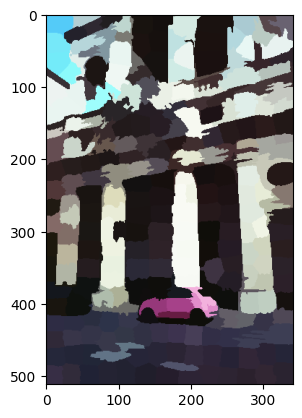

In [234]:

output_image = np.zeros_like(image)
print(output_image.shape)

for segment_label, color in zip(np.unique(segments_slic), dominant_colors):
    # print('segment_label: {}, color: {}'.format(segment_label, color))
    output_image[segments_slic == segment_label] = color

# change bgr to rgb

plt.imshow(output_image)

print(output_image.shape)

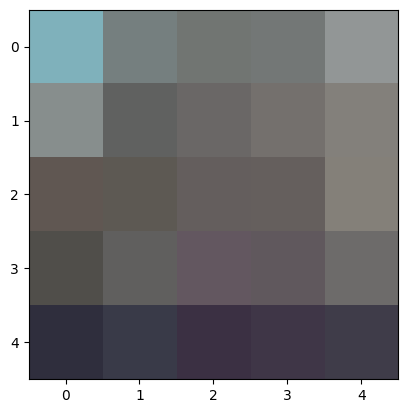

In [237]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.001
# we downsample the image by a factor of 2 (half the size)
# downsize to 5 X 5

downsampled = resize(output_image, (5,5), anti_aliasing=False)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=False, order=0)

# Display the upsampled image or process it further as needed
plt.imshow(downsampled)



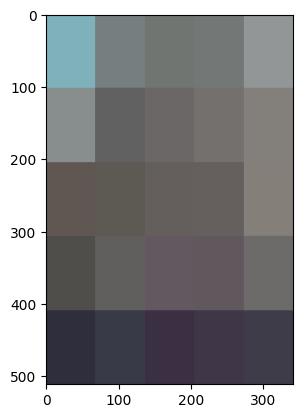

In [238]:
plt.imshow(upsampled)

In [14]:
print(upsampled.shape)

(512, 342, 3)


In [16]:
segment_ids = np.unique(segments_slic)

In [17]:
# Step 4: Assign the superpixel the color
palette = lab2rgb(dominant_colors[:, np.newaxis, :])
output_image = np.zeros_like(image)

for segment_id, color in zip(segment_ids, palette):
    mask = segments_slic == segment_id
    output_image[mask] = (color * 255).astype(np.uint8)

print(output_image.shape)

(512, 342, 3)


In [21]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.1
# we downsample the image by a factor of 2 (half the size)
downsampled = resize(output_image, (int(output_image.shape[0] * scale_down_factor), int(output_image.shape[1] * scale_down_factor)), anti_aliasing=False)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=False)

# Display the upsampled image or process it further as needed

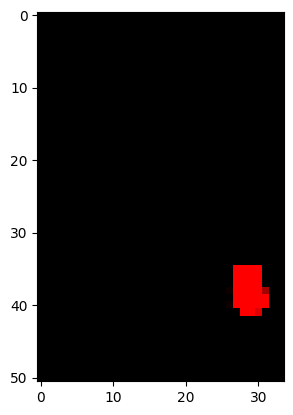

In [22]:
plt.imshow(downsampled)

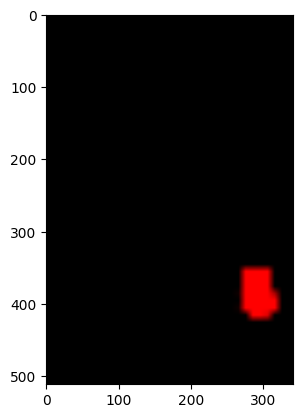

In [23]:
# plot upsamled image
plt.imshow(upsampled)